
# The Skip-gram model







## Word embeddings

The main goal of this problem is to create **word embeddings**, i.e., a mapping from words to a vector space. These vectors can indicate semantic similarities between words.
The two most popular algorithms for constructing word embeddings are **skip-gram** and **CBOW** (Continous Bag Of Words).
In both algorithms, word embeddings are learned through an auxiliary task. In CBOW, this task is predicting the current word from a window of **context** words, i.e., surrounding words. The auxiliary task under the skip-gram scheme is the opposite: given a current word, the task is predicting context words. After training, we use learned weights from the model as our word embeddings.



## Skip gram general architecture

*The global architecture of the base model of the skip-gram. Picture taken from [this website](https://www.geeksforgeeks.org/implement-your-own-word2vecskip-gram-model-in-python/)* 


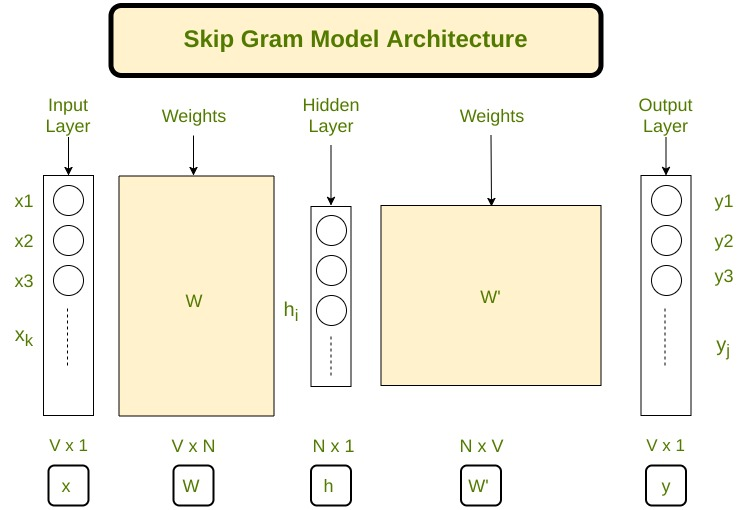


We consider a vocabulary of words $V$ for which we wish to create embeddings of dimension $N$, i.e., $\mathbf e_{wrd}(w) \in \mathbb{R}^N$. Additionally, we assume our skip-gram model considers the $T$ words preceding and following our input word in the prediction step.

The first step in the algorithm for training a skip-gram model is the processing of each sample in our training data into a (multi-) set of pairs of input and context words ($w_i$, $w_t$), where $t\in \{-T, -(T-1), \dots, T\}$ indicates the position of $w_t$ with respect to $w_i$ in the training sample. 

We project the *one-hot* encoding of our input word $\mathbf e_{oh}(w_i)\in \mathbb{R}^{|V|}$ with a weight matrix $W \in \mathbb{R}^{|V| \times N}$. This projection is then multiplied by weight matrix $W'$ and the softmax function is applied, resulting in a vector that represents the predicted probability of $w\in V$ appearing in the size $2T$ context window around word $w_i$. Our goal is to maximize the log-likelihood of our data: $\log p(w_t|w_i, W, W')$, which is typically done using gradient-descent methods.

At the end of training, we use the rows of matrix $W$ as our word embeddings, i.e., $\mathbf e_{wrd}(w_i) = W_i$.

Note: the columns of $W'$ will give us "context embeddings" $\mathbf e_{ctx}$, but we are only interested in the word embeddings.



## Negative sampling

During training, our goal is to maximize $$p(w_t\mid w_i)=\frac{1}{Z(w_i)}\exp(\mathbf e_{wrd}(w_i) \cdot \mathbf e_{ctx}(w_t)) = \frac{1}{Z(w_i)}\exp(W_i \cdot (W')^\top_t)  $$

However $Z(w)=\sum_{w' \in V} \exp(\mathbf e_{wrd}(w) \cdot \mathbf e_{ctx}(w'))$ can take a long time to compute for large $V$.
We can instead use **negative sampling**: rather than computing the $|V|$-dimensional probability distribution via the softmax, we use the sigmoid function between the ground truth label and the label of a word drawn uniformly at random from $V$. 

Formally, for each pair of words in our training data $(w_i,w_t)$, we randomly sample (with replacement) a set $C^-$ from $V$. Our objective under the negative sampling approach becomes

 $$\underset{W,W'}{\text{arg max}} \sum_{(w_i,w_t,C^-)} \left(  \log(p(w_t\mid w_i)) +  \sum_{w^- \in C^-}  \log(1-p(w^-|w_i)) \right)$$

where we compute $p(w_t\mid w_i)$ using the sigmoid function: $p(w_t|w_i) = \sigma(\mathbf e_{wrd}(w_i) \cdot \mathbf e_{ctx}(w_t))$.


# Hyperparameters

In [1]:
V_size = 12000 #size of the vocabulary
N = 300 #embedding size
window_size = 5
K= 20 #number of negative samples per positive pairs (wt,wi)

# Data loading and preprocessing

In [2]:
#!pip install nltk
import nltk
nltk.download('brown')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import brown
from nltk.corpus import stopwords 

C:\Users\Rudolf\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Rudolf\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.JPIJNSWNNAN3CE6LLI5FWSPHUT2VXMTH.gfortran-win_amd64.dll
C:\Users\Rudolf\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
  stacklevel=1)
[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\Rudolf\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rudolf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Rudolf\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
sentences = brown.sents()
print(len(sentences))
print(sentences[:3])

57340
[['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.'], ['The', 'jury', 'further', 'said', 'in', 'term-end', 'presentments', 'that', 'the', 'City', 'Executive', 'Committee', ',', 'which', 'had', 'over-all', 'charge', 'of', 'the', 'election', ',', '``', 'deserves', 'the', 'praise', 'and', 'thanks', 'of', 'the', 'City', 'of', 'Atlanta', "''", 'for', 'the', 'manner', 'in', 'which', 'the', 'election', 'was', 'conducted', '.'], ['The', 'September-October', 'term', 'jury', 'had', 'been', 'charged', 'by', 'Fulton', 'Superior', 'Court', 'Judge', 'Durwood', 'Pye', 'to', 'investigate', 'reports', 'of', 'possible', '``', 'irregularities', "''", 'in', 'the', 'hard-fought', 'primary', 'which', 'was', 'won', 'by', 'Mayor-nominate', 'Ivan', 'Allen', 'Jr.', '.']]


In [4]:
print(len(sentences))

57340


In [5]:
import string
stop_words = set(stopwords.words('english')) 
def preprocessing(sentences): 
    training_data = [] 
    for i in range(len(sentences)): 
        #sentences[i] = sentences[i].strip() 
        sentence = sentences[i] 
        x = [word.strip(string.punctuation) for word in sentence] 
        x = [word.lower() for word in x] 
        x = [word for word in x if word!='' and word.isalpha()]
        x = [word for word in x if word not in stop_words]
        if x:
            training_data.append(x) 
    return training_data 
sentences = preprocessing(sentences)
print(sentences[:3])

[['fulton', 'county', 'grand', 'jury', 'said', 'friday', 'investigation', 'recent', 'primary', 'election', 'produced', 'evidence', 'irregularities', 'took', 'place'], ['jury', 'said', 'presentments', 'city', 'executive', 'committee', 'charge', 'election', 'deserves', 'praise', 'thanks', 'city', 'atlanta', 'manner', 'election', 'conducted'], ['term', 'jury', 'charged', 'fulton', 'superior', 'court', 'judge', 'durwood', 'pye', 'investigate', 'reports', 'possible', 'irregularities', 'primary', 'ivan', 'allen', 'jr']]


# Prepare data for training


## Extract V

In [6]:
from collections import defaultdict
count = defaultdict(int)
for sentence in sentences: 
    for word in sentence: 
        count[word] += 1

In [7]:
import operator
sorted_counts = sorted(count.items(), key=operator.itemgetter(1), reverse=True)
print(sorted_counts)

[('one', 3297), ('would', 2714), ('said', 1961), ('new', 1635), ('could', 1601), ('time', 1598), ('two', 1412), ('may', 1402), ('first', 1361), ('like', 1292), ('man', 1207), ('even', 1170), ('made', 1125), ('also', 1069), ('many', 1030), ('must', 1013), ('af', 996), ('back', 966), ('years', 958), ('much', 937), ('way', 909), ('well', 897), ('people', 847), ('mr', 844), ('little', 831), ('state', 807), ('good', 806), ('make', 794), ('world', 787), ('still', 782), ('see', 772), ('men', 763), ('work', 762), ('long', 753), ('get', 749), ('life', 715), ('never', 697), ('day', 687), ('another', 684), ('know', 683), ('last', 676), ('us', 675), ('might', 672), ('great', 665), ('old', 661), ('year', 658), ('come', 630), ('since', 628), ('go', 626), ('came', 622), ('right', 613), ('states', 612), ('used', 611), ('take', 610), ('three', 610), ('house', 591), ('use', 591), ('without', 583), ('place', 570), ('american', 569), ('around', 562), ('however', 552), ('home', 547), ('small', 542), ('foun

Select the V most commons

In [8]:
vocabulary = sorted_counts[:V_size]

## Convert the corpus into indices

Many of our operations can be vectorized if we represent our words with unique ids rather than the original string. 

We assign an id to all words and create lookup tables for word to index and index to word for fast lookup. For the rest of the problem, you will work with these indices.

In [9]:
# Assign ids and create lookup tables
word_to_index = {'UNK': 0}
index_to_word = ['UNK']
for idx, tup in enumerate(vocabulary,1):
    word_to_index[tup[0]] = idx
    index_to_word.append(tup[0])

In [10]:
assert len(index_to_word) == len(word_to_index)
print(len(index_to_word))

12001


Now we can transform our dataset by replacing the words with their index.

In [11]:
sentences_index = []
for sent in sentences:
    ids=[]
    for word in sent:
        if word in word_to_index:
            ids.append(word_to_index[word])
        else: 
            ids.append(0)
    sentences_index.append(ids)
print(sentences_index[:3])

[[5128, 513, 2100, 1459, 3, 1655, 1982, 419, 959, 1231, 1027, 343, 8702, 95, 59], [1459, 3, 0, 118, 1836, 467, 713, 1231, 5373, 5129, 2730, 118, 2881, 702, 1231, 1837], [1202, 1459, 1769, 5128, 2197, 287, 1232, 0, 0, 7058, 1117, 136, 8702, 959, 0, 4520, 1262]]


Here you go ! We have preprocessed the corpus. Now it's your turn to implement the rest of the notebook, in order to extract samples, train the model and analyze the embeddings you obtain.

## Extract pair (word, context)

**Task 1.a.** : Create a list of training samples $C$: for each word $w_i$ in the corpus, add a tupple ($w_i$, $w_t$) for each context word $w_t$ in $w_i$'s context window.

Remember we defined the parameters window_size in the beginning of this notebook.

In [12]:
def extract_pair(sentences_index):
    C=[]
    for sentence_ in sentences_index:
        n=len(sentence_)
        
        for i in range(n):
            
            for j in range(i-window_size,i+window_size+1):   
                if j!=i and 0<=j <n :
                    C.append(( sentence_[i],sentence_[j] )) 
                else:
                    pass # adding w_i,w_t
    return C  

        
    

In [13]:
C=extract_pair(sentences_index)

In [14]:
print(len(C))

3571954


## Negative sampling



**Task 1.b.**: Create negative samples: for each positive sample ($w_i$, $w_t$) in $C$, we want to create a set $C^-$ of $K$ negative samples. We sample a word proportional to its number of occurences in the corpus and the negative samples should be different from the positive context word $w_t$. Store all the training data as a list of tuple ($w_i$, $w_t$, $C^-$)

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import time
import random

In C:\Users\Rudolf\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Rudolf\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Rudolf\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\Rudolf\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Rudolf\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_tes

In [16]:
#Solution task 1.b.

vocab_index=[i+1 for i in range(V_size)]   
vocab_array=np.array(vocabulary)
vocab_count=list(map(int,vocab_array[:,1] ))

# Now we can get the probabilities
vocab_prob=list((1/np.sum(vocab_count))*np.array(vocab_count))

# negative sampling function

def negative_sampling(C):
    new_C=[]
    for (w_i,w_t) in C:
        C_=[w_i,w_t]
        r=random.choices(vocab_index,vocab_prob,k=K)
        
        while w_t in r:
            r=random.choices(vocab_index,vocab_prob,k=K)
        C_+=r
        new_C.append(tuple(C_))
    return new_C
    

In [17]:
#training_data=negative_sampling(C)

In [18]:
# Saving the training data
#np.save('training_data.npy',training_data)

# Loading training data
training_data=np.load('training_data.npy')

# Learning

## Calculate gradient

Recall our training objective under the negative sampling approach. Under this objective, we can define our loss function with respect to our training data $\mathcal{D}$ as:

$$L(W,W') = - \sum_{(w_i,w_t,C^-) \in \mathcal{D}}\left (\log(\sigma(\mathbf e_{wrd}(w_i) \cdot \mathbf e_{ctx}(w_t))) +  \sum_{w^- \in C^-}  \log(1-\sigma(\mathbf e_{wrd}(w_i) \cdot e_{ctx}(w^-)))\right )$$

For the rest of the assignment you can consider the case of **Stochastic Gradient Descent**. This means at each iteration we consider only one datapoint $(w_i,w_t,C^-)$, we compute the loss and the gradients with this datapoint and update the parameters $e_{wrd}(w_i),e_{ctx}(w_t)$ and all the $e_{ctx}(w^-)$ for $w^- \in C^-$

**Task 2.a.** : Write down the partial derivative of the loss with respect to the word embedding $\mathbf e_{wrd}(w_i)$ and context embedding $\mathbf e_{ctx}(w_t)$. Additionally, provide the partial derivative of the loss with respect to a single negative sample $w^- \in C^-$: $\nabla_{\mathbf e_{wrd}(w_i)} L$, $\nabla_{\mathbf e_{ctx}(w_t)} L$, $\nabla_{\mathbf e_{ctx}(w^-)} L$


**Solution task 2.a.** :
Let $\alpha_t = e_{wrd}(w_i) \cdot e_{ctx}(w_t)$ and $\alpha^{-} = e_{wrd}(w_i) \cdot e_{ctx}(w^{-})$ <br>
Recall that $\sigma' = \sigma(1-\sigma)$ <br>
$$\nabla_{\mathbf e_{wrd}(w_i)} L = -\frac{\sigma(\alpha_t)(1-\sigma(\alpha_t))}{\sigma(\alpha_t)}e_{ctx}(w_t) + \sum_{w^{-} \in C^-}{  \frac{\sigma(\alpha^-)(1-\sigma(\alpha^-))}{1-\sigma(\alpha^-)} e_{ctx}(w^{-}) } $$
Hence: 
$$\nabla_{\mathbf e_{wrd}(w_i)} L = (-1+\sigma(e_{wrd}(w_i) \cdot e_{ctx}(w_t)))e_{ctx}(w_t)+ \sum_{w^{-} \in C^-}{\sigma(e_{wrd}(w_i) \cdot e_{ctx}(w^{-}))e_{ctx}(w^{-})}  $$
Similarly we have :
$$\nabla_{\mathbf e_{ctx}(w_t)} L =(-1+\sigma(e_{wrd}(w_i) \cdot e_{ctx}(w_t))) e_{wrd}(w_i) $$

$$\nabla_{\mathbf e_{ctx}(w^-)} L = \sigma(e_{wrd}(w_i) \cdot e_{ctx}(w^{-})) e_{wrd}(w_i)$$


**Task 2.b** : Write down the formula of the gradient update of $\mathbf e_{wrd}(w_i)$, $\mathbf e_{ctx}(w_t)$ and $\mathbf e_{ctx}(w^-)$.

**Solution task 2.b. :**
By denoting $\eta$ the learning rate we have: 
$$ \theta:= \theta - \eta \nabla_{\theta}L$$ with $\theta \in \{e_{wrd}(w_i), e_{ctx}(w_t),e_{ctx}(w^-) \}$ and L the loss.


## Training

**Task 3 :** With the dataset of positive and negative samples you created, implement the gradient descent algorithm. You have to initialize the matrices W and W' with random weights between -0.8 and 0.8, compute the gradients efficiently and launch the training on several epochs. Draw the curve of the loss in function of the total number of steps.

In [19]:
#training params     
# Error for lr=0.03 
lr = 0.01
epochs = 11      

In [20]:
#Solution task 3

# Matrix W and W' initialization
W=1.6*np.random.rand(V_size+1,N)-0.8*np.ones((V_size+1,N))
W_ = 1.6*np.random.rand(N,V_size+1)-0.8*np.ones((N,V_size+1))

In [20]:
def sigmoid(x):
    return 1/(1+np.exp(-x))


Loss_list=[]
# Stochastic Gradient Descent
data_size=len(training_data)
def gradient_descent(lr,epochs):
    
    
    # Initial loss computation 
    for i in range(data_size):
        index_list = training_data[i]

        # Word to embbeding
        emb=[W[index_list[0],:]]+[W_[:,index] for index in index_list[1:] ]
        # Sigmoid of the scalar product

        S=[1]+[sigmoid(np.dot(emb[0],emb[i])) for i in range(1,K+2) ]
        Loss_list.append( [-np.log(S[1])-np.sum([np.log(1-S[i]) for i in range(2,K+2)])])
    
    print('epoch : ', 0,'---------------------------------> first word loss : ',Loss_list[0][-1])
    
    for ep in range(epochs):
        
        for i in range(data_size):
            index_list = training_data[i]
            
            # Word to embbeding
            emb=[W[index_list[0],:]]+[W_[:,index] for index in index_list[1:] ]
            # Sigmoid of the scalar product
            
            S=[1]+[sigmoid(np.dot(emb[0],emb[i])) for i in range(1,K+2) ] 
            # weights update
            
            # W_(-) update
            for j in range(2,K+2):
                W_[:,index_list[j]]-=lr*S[j]*emb[0]
            
            # w_t update
            W_[:,index_list[1]]-=lr*((-1+S[1])*emb[0])
            
            # w_i update
            new_vect=-emb[1]
            for k in range(1,K+2):
                new_vect+=S[k]*emb[k]
            
            W[index_list[0],:] -=lr*new_vect
            
            # Loss update computation
            
            # new Word to embbeding
            emb_=[W[index_list[0],:]]+[W_[:,index] for index in index_list[1:] ]
            
            # new Sigmoid of the scalar product
            
            S_=[1]+[sigmoid(np.dot(emb_[0],emb_[i])) for i in range(1,K+2) ]
            
            # adding the loss in a list
            Loss_list[i].append(-np.log(S_[1])-np.sum([np.log(1-S_[i]) for i in range(2,K+2)]))
        
        # printing the loss
        print('epoch : ', ep+1,'---------------------------------> first word loss : ',Loss_list[0][-1])
        
            
    plt.plot(Loss_list[0])
    plt.show()
            
            
        

epoch :  0 ---------------------------------> first word loss :  31.946893949477992
epoch :  1 ---------------------------------> first word loss :  8.102744721708659
epoch :  2 ---------------------------------> first word loss :  0.427263581675824
epoch :  3 ---------------------------------> first word loss :  0.33871956476873766
epoch :  4 ---------------------------------> first word loss :  0.2858973827495167
epoch :  5 ---------------------------------> first word loss :  0.25507550784244226
epoch :  6 ---------------------------------> first word loss :  0.8438681948723068


C:\Users\Rudolf\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


epoch :  7 ---------------------------------> first word loss :  3.169349894970893
epoch :  8 ---------------------------------> first word loss :  4.094866542067873


C:\Users\Rudolf\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in log


epoch :  9 ---------------------------------> first word loss :  1.5212598821915977
epoch :  10 ---------------------------------> first word loss :  0.628034626794421


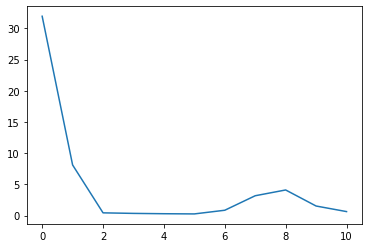

In [58]:
gradient_descent(lr,epochs)

In [ ]:
# Saving W
#np.save('Wmatrix.npy',W)

# Saving W_
#np.save('W_matrix.npy',W_)

In [21]:
# loading W
W=np.load('Wmatrix.npy')

# loading W_
#W_=np.load('W_matrix.npy')

Now you can use the matrix W for words embeddings.

We recommend you to save your embedding matrix for the rest of the problem. You have to hand it in with your assignment so that we can reproduce your results.

# Analyzing the embeddings

## Cosine similarity calculation

One way to compare vectors is the cosine similarity, which is defined as :
$$sim(\mathbf x,\mathbf y) = \frac{\mathbf x \cdot \mathbf y}{||\mathbf x|| ||\mathbf y||}$$

**Task 4.a.** : Fill the tables with the cosine similarity between the given words and comment the results :


| x      | y       | sim(x,y)     | 
|--------|---------|--------------|
|film    |movie    | 0.20         |
|film    |water    | 0.09             |
|home    |house    | 0.38             |
|home    |yellow   | 0.20             |
|father  |mother   | 0.33             |
|father  |street   | 0.19             |
|street  |avenue   | 0.23             |
|writer  |poet     | 0.23             |
|writer  |potatoes | 0.15             |
|boy     |girl     | 0.29             |
|children|young    | 0.30             |
|children|old      | 0.29             |
|eat     |food     | 0.26             |
|eat     |sport    | 0.11             |
|water   |liquid   | 0.24             |
|water   |solid    | 0.22             |








The similarities are very close to each other even if the words are not very close. However we can see a good correlation between similar values having a similarity above $0.19$. Home and yellow are very similar which is probably due to an error of our model. What is interesting is that our model retain the fact that water can be both solid and liquid, or maybe it is also an error.

In [22]:
#Solution task 4.a.
def cos_sim(x,y):
    xx=W[word_to_index[x],:]
    yy=W[word_to_index[y],:]
    return np.dot(xx,yy)/(np.linalg.norm(xx)*np.linalg.norm(yy))
def vect_sim(Lx,Ly):
    
    for i in range(len(Lx)):
        print(Lx[i],Ly[i],'---------------------->',cos_sim(Lx[i],Ly[i]))
    

In [23]:
Lx=['film','film','home','home','father','father','street','writer','writer','boy','children','children','eat','eat','water','water']
Ly=['movie','water','house','yellow','mother','street','avenue','poet','potatoes','girl','young','old','food','sport','liquid','solid']

In [24]:
sim_vector=vect_sim(Lx,Ly)

film movie ----------------------> 0.20326520462975758
film water ----------------------> 0.09551567631014081
home house ----------------------> 0.38996832477775717
home yellow ----------------------> 0.20368094949362564
father mother ----------------------> 0.33848982721852633
father street ----------------------> 0.19489037089013334
street avenue ----------------------> 0.2349774616580319
writer poet ----------------------> 0.23033459484974758
writer potatoes ----------------------> 0.15298725586781378
boy girl ----------------------> 0.2970780174997944
children young ----------------------> 0.30281243087543436
children old ----------------------> 0.29990860046737533
eat food ----------------------> 0.2678910300699644
eat sport ----------------------> 0.11179878663800043
water liquid ----------------------> 0.24584929909036976
water solid ----------------------> 0.22126396771094728


**Task 4.b.** Show the 10 nearest words of the following words with the associated cosine similarity values : [*love, car, president, monday, green, money, health, faith, book, france, swiss, spring*] along with 5 words of your choice. Provide a brief description of your observations.



In [ ]:
import seaborn as sns

In [25]:
#Solution task 4.b.

def close_words(word_list,k): # k the number of nearest words
    G=[]
    for word in word_list:
        
        L=np.array([cos_sim(word,index_to_word[i]) for i in range(V_size) ])
        index_=L.argsort()[-k-1:][::-1]  # k+1 words because the first is the same word
        G.append([(index_to_word[i],L[i]) for i in index_ ])
    return G
        


In [ ]:
C_words=close_words(['love','car', 'president', 'monday', 'green',
                   'money', 'health', 'faith', 'book', 'france',
                   'swiss', 'spring', 'school','game','program','computer','college'],10)

In [30]:
for word in C_words:
    print(word)
    print('---------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------')
    

[('love', 0.9999999999999999), ('know', 0.41167752987945677), ('face', 0.39957844466798054), ('man', 0.3757264402389455), ('come', 0.3662799947060269), ('little', 0.35737589080448257), ('eyes', 0.35146611338866796), ('softly', 0.35099967136626853), ('feel', 0.34932581682013736), ('wonderful', 0.3492538108775592), ('still', 0.3477917284201964)]
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
[('car', 1.0000000000000002), ('cars', 0.3849053655557061), ('almost', 0.3756986877953135), ('front', 0.35500040891739815), ('police', 0.3441432565017739), ('driving', 0.33491720952581827), ('house', 0.33414664071217776), ('parked', 0.33406192456860706), ('station', 0.3325324268358796), ('driven', 0.3320673996361747), ('sit', 0.3304060212609772)]
---------------------------------------------------------------------------------------
-----------------------------------------

We can first noticed that the first word which has the highest similarity with the initial word is the word itself. For words written in singular the plural expression usually comes after, for example with game, program, car. Even if the orders are not always believable, the close words seem to be close to the initial word. Sometimes there is an awkward apparition of some words, like with jail and spring, congo and France ( Congo appears before Paris), monday with legislators. The word swiss seems to give completly wrong words; it may be due to the dataset. Overall the results are quite good and can certainly be improved.

## Words analogies

**Task 5** : As explained in class, we can also evaluate word embeddings with word analogies.
Compare the cosine similarities between following vectors and comment on the results. Find 2 other such examples.

| x                            | y       | sim(x,y)     | 
|------------------------------|---------|--------------|
|london - england + germany    | berlin  |    0.21          |
|father - man + woman          |mother   |    0.30          |
|children - young + old        |parents  |    0.18          |
|sister - girl + boy           |brother  |    0.34          |
|happiness - good + bad        |pain     |    0.16          |


In [31]:
def word_analogies(X_list,y_list):
    Sim=[]
    for i in range(len(X_list)):
        xx=W[word_to_index[X_list[i][0]],:] - W[word_to_index[X_list[i][1]],:] + W[word_to_index[X_list[i][2]],:]
        yy = W[word_to_index[y_list[i]],:]
        Sim.append(np.dot(xx,yy)/(np.linalg.norm(xx)*np.linalg.norm(yy)))
    return Sim


In [32]:
X_list=[['london','england','germany'],['father','man','woman'],['children','young','old'],['sister','girl','boy'],['happiness','good','bad']]
y_list=['berlin','mother','parents','brother','pain']

In [33]:
print(word_analogies(X_list,y_list))

[0.21723487231274022, 0.30057669735347814, 0.18264954625701138, 0.34256911590769146, 0.16377194020729924]


We can see that most of the time the model capture the addition and substraction pattern. For berlin, mother and brother the similarity is above 0.19 and we can assume that the words are close. Old children (adults) are not necessarily parents, that maybe the reason why the similarity is just below 0.19. Something bad is not necessarily painful especially for someone doing a bad thing. The result for pain seems reasonable.

# Visualization

**t-distributed stochastic neighbor embedding ([t-SNE](https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf))** is a statistical method for visualizing high-dimensional data by giving each datapoint a location in a two or three-dimensional map.




The following code transforms the embeddings of W from dimension N to dimension 2.

In [36]:
from sklearn.manifold import TSNE

labels = []
tokens = []

for i in range(len(index_to_word)):
    tokens.append(W[i,:])
    labels.append(index_to_word[i])

In [ ]:
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
new_values = tsne_model.fit_transform(tokens)

In [37]:
new_values=np.load('new_values.npy')


**Task 6** : Plot 3 graphs with the 2D coordinates of the first 100, 500 and 1000 words with their labels. Analyze the results, in particular identify some thematic clusters that your visualizations reveal.

In [41]:
import pandas as pd
import seaborn as sns
%matplotlib notebook

In [48]:
def graph_2D(labels,tokens,N_max):
    nlabel=labels[:N_max]
    ntokens=tokens[:N_max]
    data_fr=pd.DataFrame({'x': ntokens[:, 0], 'y': ntokens[:, 1]})
    sns.lmplot('x','y',data=data_fr, fit_reg=False, # Don't fix a regression line
        size = 4,
        aspect =2 )
    a = pd.concat({'x': data_fr.x, 'y': data_fr.y, 'val': pd.Series(nlabel)}, axis=1)
    for i, point in a.iterrows():
        plt.gca().text(point['x']+.002, point['y'], str(point['val']))

<IPython.core.display.Javascript object>


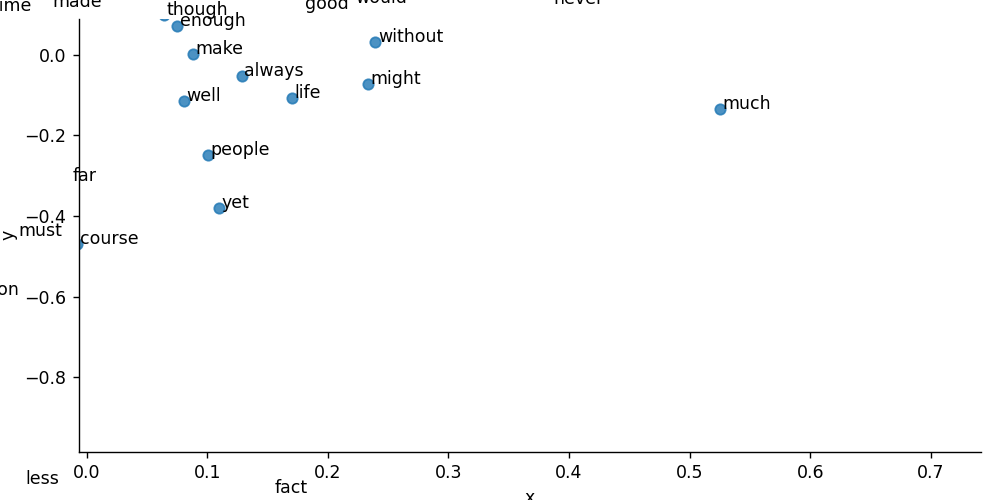

<IPython.core.display.Javascript object>


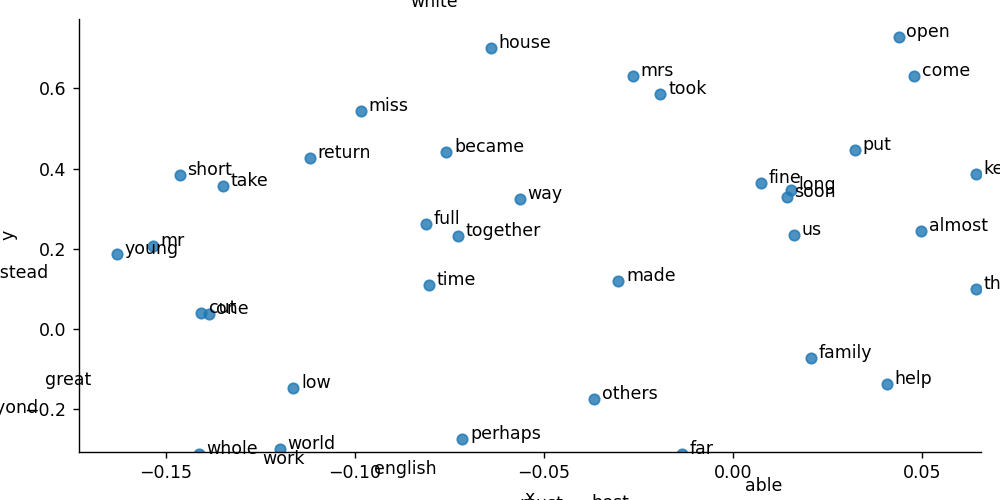

<IPython.core.display.Javascript object>


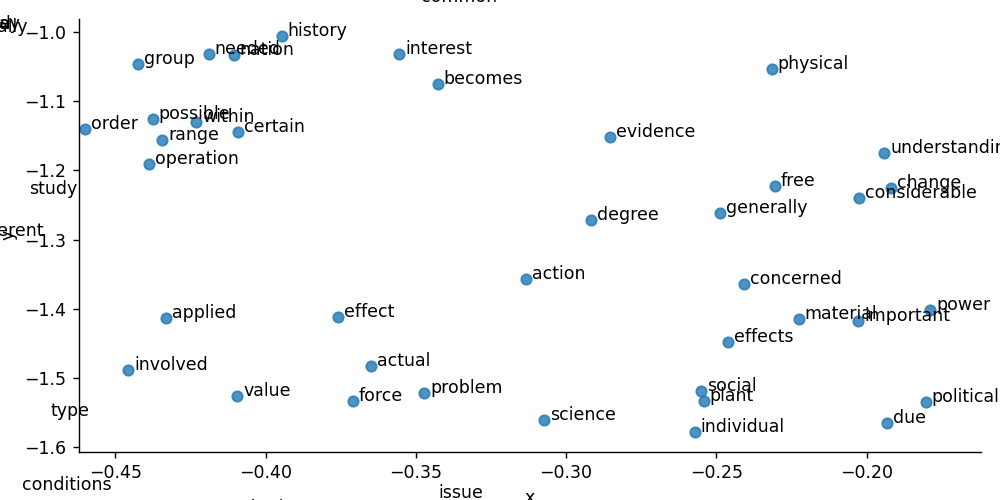

In [51]:
for N_max in [100,500,1000]:
    graph_2D(labels,new_values,N_max)

We can see that the 'UNK', which is the denomination for the unkown words is alone in it cluster. There is also a cluster with only the word even that can only be explained by an error in the model. We can notice a cluster with the words {went,left,around,got,away}. There is also a cluster about health with the words {health,well,reach,always,read,life,make,find,enough,family,help,read, book, people, sometimes}